# Imports

In [2]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
from keras.utils import np_utils
import GPyOpt
from sklearn.model_selection import ParameterSampler

2023-02-18 12:10:25.399802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X[1].shape)
#plt.imshow(train_X[1], cmap = "Greys")
#plt.show()

# one-out-of-k encoding of the labels
# using keras' numpy-related utilities
n_classes = 10
print("Shape (train) before one-hot encoding: ", train_y.shape)
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print("Shape (train) after one-hot encoding: ", Y_train.shape)

(28, 28)
Shape (train) before one-hot encoding:  (60000,)
Shape (train) after one-hot encoding:  (60000, 10)


# CNN Model

In [4]:
CNN = ks.models.Sequential()
# convolutional layer
CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
# flatten output of conv
CNN.add(ks.layers.Flatten())
# hidden layer
CNN.add(ks.layers.Dense(100, activation='relu'))
# output layer
CNN.add(ks.layers.Dense(10, activation='softmax'))

CNN.summary()

CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

CNN.fit(train_X, Y_train, batch_size = 32)

acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
print(acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 25)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4225)              0         
                                                                 
 dense (Dense)               (None, 100)               422600    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 423,860
Trainable params: 423,860
Non-trainable params: 0
__________________________________________________

2023-02-18 12:10:31.622457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 1s 2ms/step - loss: 0.1200 - accuracy: 0.9675
0.9674999713897705


# Bayesian Optimization

In [5]:
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)


# define the dictionary for GPyOpt
domain = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
]

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    print(param)

    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(100, activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = 32)
    acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_nodes=" + str(x_best[0]))
print(opt.Y.shape)

[30.]
313/313 [==============================] - 1s 2ms/step - loss: 0.1352 - accuracy: 0.9637
0.963699996471405
[86.]
313/313 [==============================] - 1s 2ms/step - loss: 0.1203 - accuracy: 0.9679
0.9678999781608582
[26.]
313/313 [==============================] - 1s 2ms/step - loss: 0.1438 - accuracy: 0.9619
0.961899995803833
[89.]
313/313 [==============================] - 1s 2ms/step - loss: 0.1255 - accuracy: 0.9662
0.9661999940872192
[78.]
313/313 [==============================] - 1s 2ms/step - loss: 0.1048 - accuracy: 0.9715
0.9714999794960022
[69]
313/313 [==============================] - 1s 2ms/step - loss: 0.1113 - accuracy: 0.9680
0.9679999947547913
[76]
313/313 [==============================] - 1s 2ms/step - loss: 0.0985 - accuracy: 0.9707
0.9707000255584717
[80]
313/313 [==============================] - 1s 2ms/step - loss: 0.1023 - accuracy: 0.9677
0.9677000045776367
[76]
313/313 [==============================] - 1s 2ms/step - loss: 0.1017 - accuracy: 0.9706

# Random Search

In [6]:
import time 

# hyperparams dictionary 

domain = {"n_nodes": n_nodes}

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)
#rounded_list = [dict((k,v) for (k, v) in d.items()) for d in param_list]

#print('Random parameters we are going to consider')
#print(rounded_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_acc = 0
iteration_best_acc = 0 
max_acc_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(100, activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    CNN.fit(train_X, Y_train, batch_size = 32)
    end = time.time()
    acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
    print('Accuracy found:', acc)
    if acc > current_best_acc:
        current_best_acc = acc
        iteration_best_acc = i
    
    max_acc_per_iteration.append(current_best_acc)
    i += 1
    print(f'It took {end - start} seconds')
    

Param list
[{'n_nodes': 23}, {'n_nodes': 40}, {'n_nodes': 86}, {'n_nodes': 98}, {'n_nodes': 56}, {'n_nodes': 34}, {'n_nodes': 81}, {'n_nodes': 14}, {'n_nodes': 28}, {'n_nodes': 97}, {'n_nodes': 45}, {'n_nodes': 47}, {'n_nodes': 59}, {'n_nodes': 24}, {'n_nodes': 49}, {'n_nodes': 85}, {'n_nodes': 3}, {'n_nodes': 67}, {'n_nodes': 64}, {'n_nodes': 37}]
0
{'n_nodes': 23}
313/313 [==============================] - 1s 2ms/step - loss: 0.1127 - accuracy: 0.9675
Accuracy found: 0.9674999713897705
It took 9.227346897125244 seconds
1
{'n_nodes': 40}
313/313 [==============================] - 1s 2ms/step - loss: 0.1008 - accuracy: 0.9702
Accuracy found: 0.9702000021934509
It took 9.380551815032959 seconds
2
{'n_nodes': 86}
313/313 [==============================] - 1s 2ms/step - loss: 0.1127 - accuracy: 0.9686
Accuracy found: 0.9685999751091003
It took 9.372099876403809 seconds
3
{'n_nodes': 98}
313/313 [==============================] - 1s 2ms/step - loss: 0.0963 - accuracy: 0.9742
Accuracy found

# Comparison

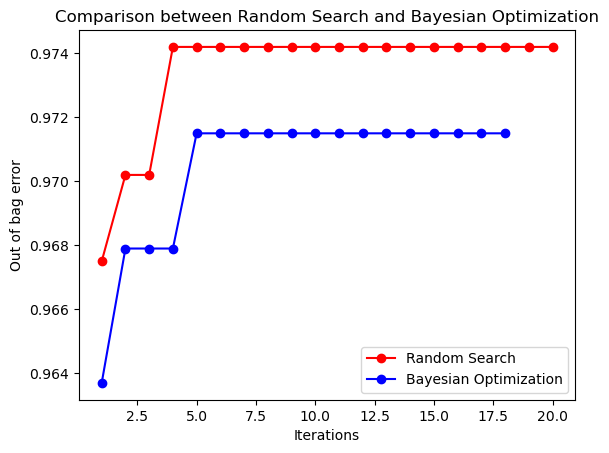

In [7]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO, note that it is also provided by GPOpt in Y_Best
y_bo = np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)
xp = np.arange(1,y_bo.shape[0] + 1,1)

plt.plot(xs, max_acc_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xp, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Out of bag error')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

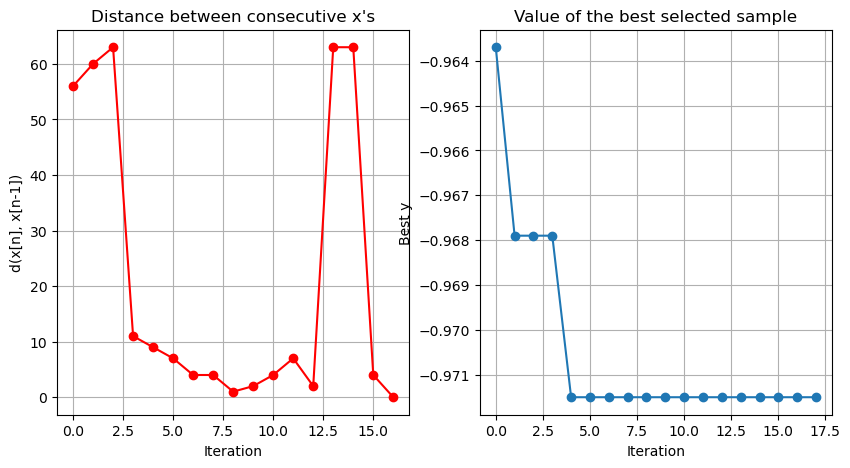

In [13]:
#opt.plot_acquisition() #Virker først med 2D
opt.plot_convergence()
"""We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample."""